# Preprocesado de datos para clustering

In [146]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import time

from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin

In [85]:
__INTERIM_DATA_PATH__ = "../data/interim"
__PROCESSED_DATA_PATH__ = "../data/processed"

__OUTPUT_DF_NAME__ = "easy_money_processed"

## Classes

In [88]:
class ArrayToDataFrame(BaseEstimator, TransformerMixin):
    '''
    Clase que transforma un array en un DataFrame.
    Necesita como parámetros el nombre de las columnas y el índice.
    '''

    def __init__(self, columns, index=None):
        self.columns = columns
        self.index = index

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if self.index is not None:
            df = pd.DataFrame(X, columns=self.columns, index=self.index)
        else:
            df = pd.DataFrame(X, columns=self.columns)
        return df


class FeatureGenerator(BaseEstimator, TransformerMixin):
    """
    Clase que realiza unas transformaciones en el Pipeline.
    El dataset que le pasas debe ser un DataFrame válido.
    """

    def __init__(self, index: str):
        self.index = index

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        index = self.index if self.index else X.index
        return X.groupby(index).agg(
            # active_customer
            active_customer_mean=("active_customer", np.mean),
            active_customer_last=("active_customer", self.__get_last_value),

            # salary
            salary_mean=("salary", np.mean),
            salary_last=("salary", self.__get_last_value),

            # age
            age_mean=("age", np.mean),
            age_last=("age", self.__get_last_value)
        )

    def __get_last_value(self, serie: pd.Series):
        return serie.iloc[-1]


class OutlierFilter(BaseEstimator, TransformerMixin):
    '''
    Clase que filtra los outliers utilizando np.quantile()
    Los cuantiles a filtrar así como las columnas a filtrar son los parámetros de la clase.
    '''

    def __init__(self, q, col_to_filter):
        self.q = q
        self.col_to_filter = col_to_filter

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        '''
        El método considera outlier a aquel cliente que es outlier en todas las columnas que le pasas.
        Es decir: si tiene que filtrar importe y número de pedidos, sólo va a eliminar aquellos clientes
        que son outlier tanto en importe como número de pedidos. Si eres outlier en importe pero no en pedido
        no se te va a filtrar del dataset.
        '''

        # lista vacía
        criteria_list = []

        # agregamos a la lista los clientes que son outliers
        for col in self.col_to_filter:
            criteria = X[col] < np.quantile(X[col], q=self.q)
            criteria_list.append(criteria)

        # si hay más de 1 columna
        if len(self.col_to_filter) > 1:

            # creamos el criterio global: es decir outlier en todas las columnas
            global_criteria = criteria_list[0]

            for criteria in criteria_list[1:]:
                global_criteria = global_criteria & criteria

        else:
            global_criteria = criteria_list[0]

        # filtramos nuestra dataframe
        X = X[global_criteria]

        # guardamos el índice como parámetro de la clase porque en caso contrario lo perderíamos.
        self.index = X.index

        return X

## Import data

In [24]:
df = pd.read_csv(f"{__INTERIM_DATA_PATH__}/easy_money_prep_1.csv")
df.drop("Unnamed: 0", axis=1, inplace=True)
df["pk_partition"] = pd.to_datetime(df["pk_partition"])
df.shape

(5962863, 33)

## Processing

In [106]:
pipe = Pipeline(steps=[
    ("FeatureGenerator", FeatureGenerator("pk_cid")),
    ("OutlierFilter", OutlierFilter(q = 0.99, col_to_filter = ["salary_mean", "salary_last"]))
])

In [107]:
result_pipe1_df = pipe.fit_transform(df)

In [108]:
pipe2 = Pipeline(steps=[
    ("scale", MinMaxScaler()),
    ("array_to_dataframe", ArrayToDataFrame(index=result_pipe1_df.index, columns=result_pipe1_df.columns))
])

In [110]:
processed_df = pipe2.fit_transform(result_pipe1_df)

In [100]:
# result_df.to_csv(f"{__PROCESSED_DATA_PATH__}/{__OUTPUT_DF_NAME__}.csv")

In [111]:
def generate_clusters(dataframe: pd.DataFrame, min_cluster: int = 2, max_cluster: int = 10):
    st = time.time()
    sse = {}
    for k in range(min_cluster, max_cluster):
        print(f"Fitting pipe with {k} clusters")
        _clustering_model = KMeans(n_clusters=k)
        _clustering_model.fit(dataframe)
        sse[k] = _clustering_model.inertia_

    et = time.time()
    print("Elbow curve took {} minutes.".format(round((et - st) / 60), 2))

    return sse

In [114]:
sse = generate_clusters(processed_df, 2, 15)

Fitting pipe with 2 clusters
Fitting pipe with 3 clusters
Fitting pipe with 4 clusters
Fitting pipe with 5 clusters
Fitting pipe with 6 clusters
Fitting pipe with 7 clusters
Fitting pipe with 8 clusters
Fitting pipe with 9 clusters
Fitting pipe with 10 clusters
Fitting pipe with 11 clusters
Fitting pipe with 12 clusters
Fitting pipe with 13 clusters
Fitting pipe with 14 clusters
Elbow curve took 2 minutes.


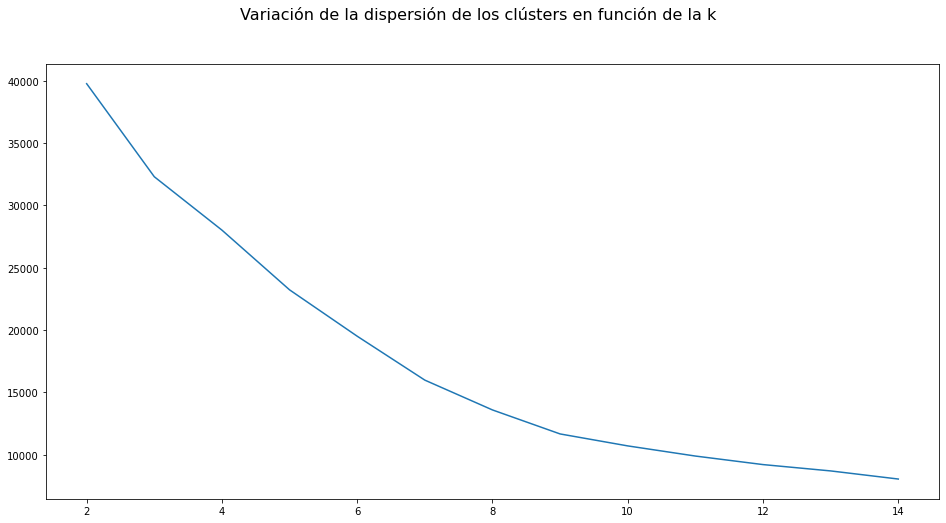

In [115]:
def plot_elbow(sse):
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot()

    x_values = list(sse.keys())
    y_values = list(sse.values())

    ax.plot(x_values, y_values, label="Inertia/dispersión de los clústers")
    fig.suptitle("Variación de la dispersión de los clústers en función de la k", fontsize=16)


plot_elbow(sse)

In [138]:
pipeline = Pipeline(steps=[
    ("FeatureGenerator", FeatureGenerator("pk_cid")),
    ("OutlierFilter", OutlierFilter(q = 0.99, col_to_filter = ["salary_mean", "salary_last"])),
    ("scale", MinMaxScaler()),
    ("Clustering", KMeans(n_clusters=6))
])

In [139]:
processed_df = pipeline.fit(df)

In [140]:
X_processed = pipeline[0].transform(df)

In [141]:
X_scaled = pipeline[2].transform(X_processed)

In [142]:
X_scaled.shape

(456373, 6)

In [143]:
labels = pipeline["Clustering"].predict(X_scaled)

In [144]:
X_processed["cluster"] = labels

In [145]:
X_processed.shape

(456373, 7)

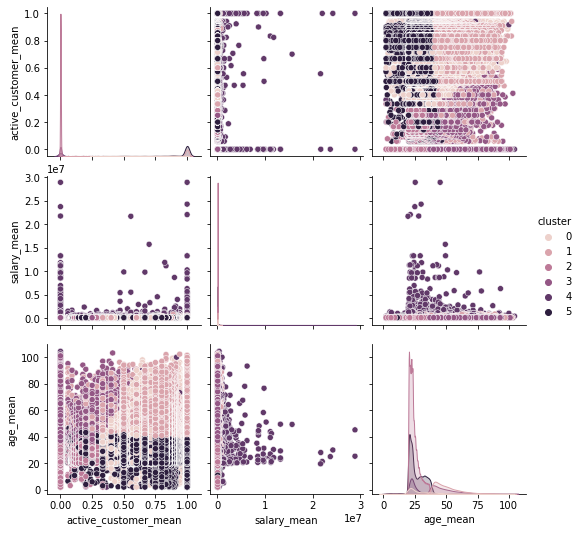

In [148]:
sns.pairplot(X_processed, vars=["active_customer_mean", "salary_mean", "age_mean"], hue="cluster")